# Exogenous Variables: Time Series Analysis

If we decide to use exogenous variables to predict ADP in the future, we will need to predict the values of these variables in order have inputs for our predictive model. Therefore, we need to analyze the trends of the exogenous variables so we can determine how to predict the twelve future values.

We are mainly concerned with admission and discharge counts and length of stay. We will analysis these as timeseries using SARIMAX package.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from functions import *
%matplotlib inline

In [2]:
_30day_pop_tot = pd.read_csv("../Data/_30_day_adp.csv", index_col = 0)
#specify data types for start and end date
_30day_pop_tot['Start Date'] = _30day_pop_tot['Start Date'].astype('datetime64[ns]')
_30day_pop_tot['End Date'] = _30day_pop_tot['End Date'].astype('datetime64[ns]')

_30day_pop_tot.head()

,Start Date,End Date,ADP
0,2021-07-17,2021-08-15,5914.0
1,2021-08-16,2021-09-14,6023.0
2,2021-09-15,2021-10-14,5808.0
3,2021-10-15,2021-11-13,5526.0
4,2021-11-14,2021-12-13,5410.0


In [3]:
joined_ivs_df = pd.read_csv("../Data/_30_day_IVs.csv", index_col = 0)
#specify data types for start and end date
joined_ivs_df['Start Date'] = joined_ivs_df['Start Date'].astype('datetime64[ns]')
joined_ivs_df['End Date'] = joined_ivs_df['End Date'].astype('datetime64[ns]')
joined_ivs_df.head()

,Start Date,End Date,admission_count,discharge_count,los_days
0,2021-07-17,2021-08-15,1524,1343,123
1,2021-08-16,2021-09-14,1396,1282,110
2,2021-09-15,2021-10-14,1329,1780,114
3,2021-10-15,2021-11-13,1263,1351,104
4,2021-11-14,2021-12-13,1273,1271,120


In [4]:
_30day_pop_tot['Date_Rank'] = _30day_pop_tot.sort_values(by = 'Start Date').index
_30day_pop_tot['sqrt_Date_Rank'] = np.sqrt(_30day_pop_tot['Date_Rank'])
_30day_pop_tot['adp_lag4'] = _30day_pop_tot['ADP'].shift(4).fillna(0)

#join DV and IV dataframes
_30day_pop_tot = _30day_pop_tot.merge(joined_ivs_df, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])
#check to see if we have an NaNs from left join, if so we will replace with ma(2) term
if len(_30day_pop_tot) == len(joined_ivs_df) and _30day_pop_tot['End Date'].iloc[-1] == joined_ivs_df['End Date'].iloc[-1]:
    pass
else:
    # Fill NaN values using moving average of the previous 2 terms
    for col in joined_ivs_df.columns.to_list()[2:]:
        _30day_pop_tot[col].fillna(_30day_pop_tot[col].rolling(3, min_periods=1).mean(), inplace=True)
#define admit_lag3 IV and date rank vars
_30day_pop_tot['admit_lag3'] = _30day_pop_tot['admission_count'].shift(3).fillna(0)
_30day_pop_tot.tail()

,Start Date,End Date,ADP,Date_Rank,sqrt_Date_Rank,adp_lag4,admission_count,discharge_count,los_days,admit_lag3
28,2023-11-04,2023-12-03,6152.0,28,5.291503,6170.0,1741,1691,96,1772.0
29,2023-12-04,2024-01-02,6061.0,29,5.385165,6192.0,1518,1707,106,1843.0
30,2024-01-03,2024-02-01,6124.0,30,5.477226,6189.0,1930,1781,100,1856.0
31,2024-02-02,2024-03-02,6217.0,31,5.567764,6176.0,1930,1829,96,1741.0
32,2024-03-03,2024-04-01,6290.0,32,5.656854,6152.0,1930,1805,98,1518.0


The model we are choosing could potentially be trained on admission and discharge counts as well as length of stay in days. We will need the future (predicted values) for these variables to predict future ADP. I am going to do so using an ARIMA model to do so.

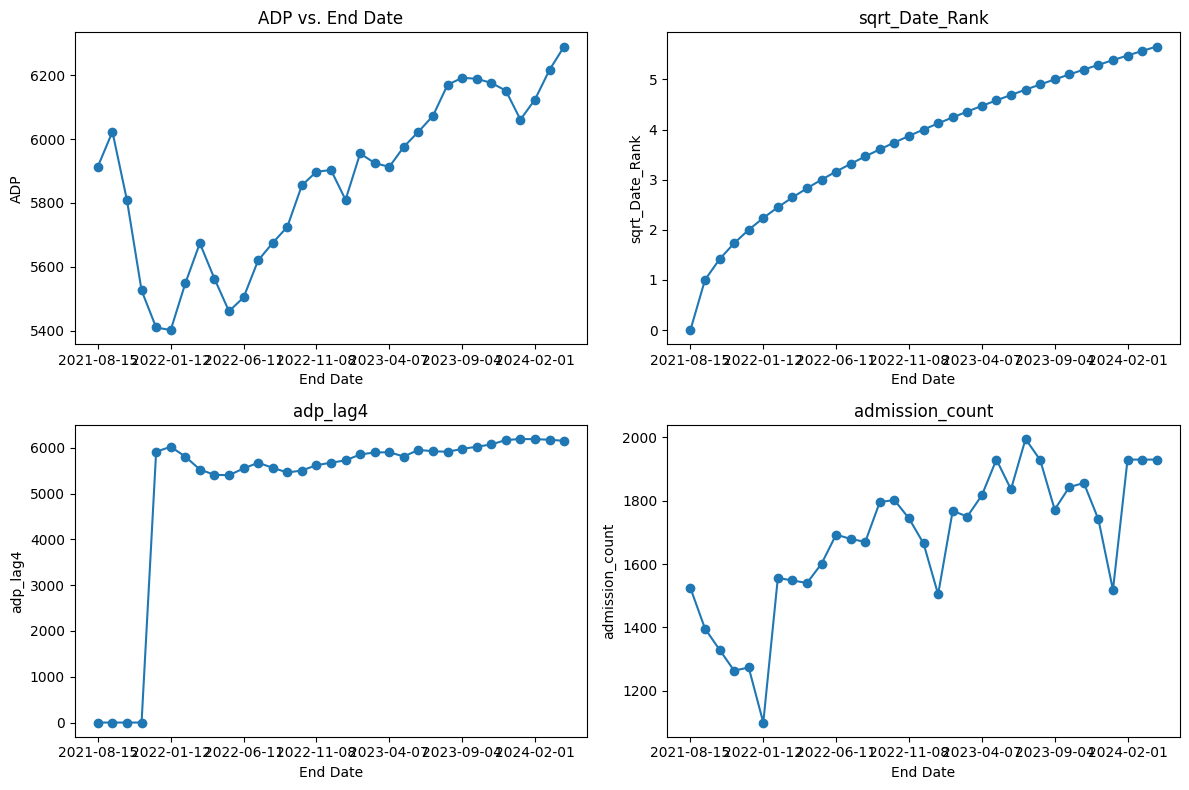

In [8]:
#plot of the features in time
# Convert 'End Date' to datetime format
_30day_pop_tot['End Date'] = pd.to_datetime(_30day_pop_tot['End Date'])

# Create a figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot each subplot
variables = ['ADP', 'sqrt_Date_Rank', 'adp_lag4', 'admission_count']
titles = ['ADP vs. End Date', 'sqrt_Date_Rank', 'adp_lag4', 'admission_count']

for i, ax in enumerate(axs.flat):
    if i == 0:
        ax.plot(_30day_pop_tot['End Date'], _30day_pop_tot[variables[i]],'-o')
    else:
        ax.plot(_30day_pop_tot['End Date'], _30day_pop_tot[variables[i]],'-o')
    ax.set_title(titles[i])
    ax.set_xlabel('End Date')
    ax.set_ylabel(variables[i])
    ax.set_xticks(_30day_pop_tot['End Date'][::5])  # Plot every 5th date label

# Adjust layout
plt.tight_layout()
plt.show()

Decompose the signals into trend, seasonality, and residuals

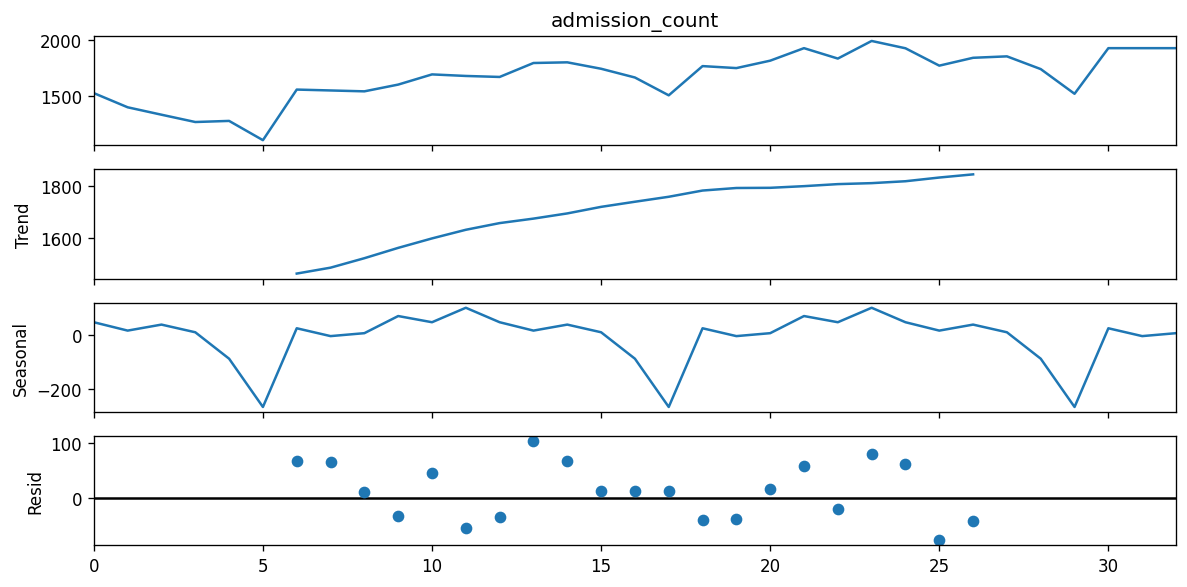

In [71]:
#decompose the monthly admission count
results = seasonal_decompose(_30day_pop_tot['admission_count'],model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

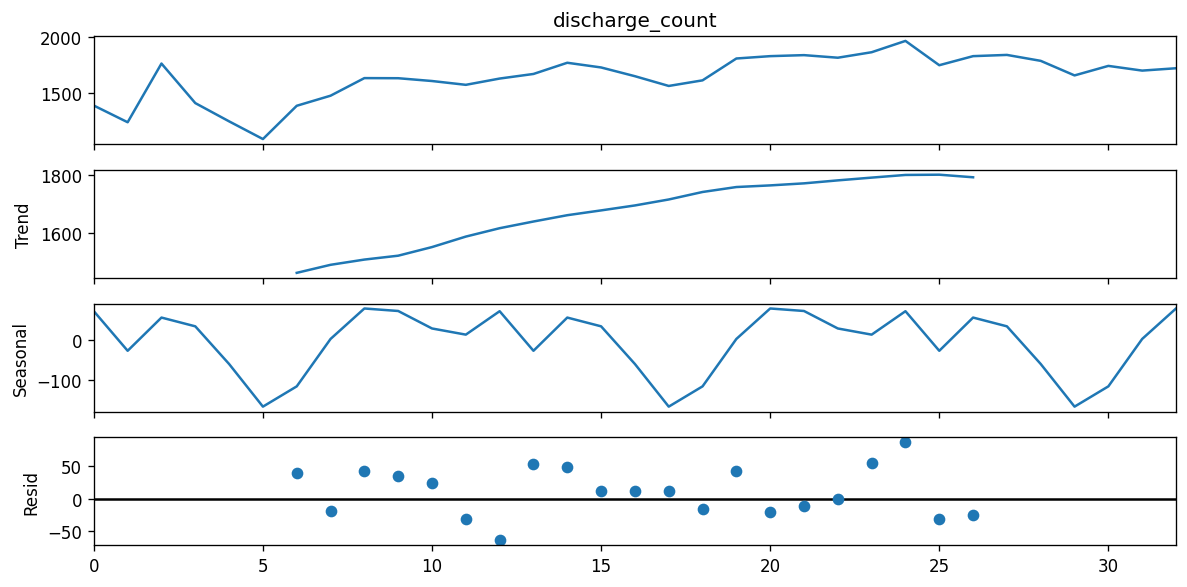

In [44]:
#decompose the monthly admission count
results = seasonal_decompose(_30day_pop_tot['discharge_count'],model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

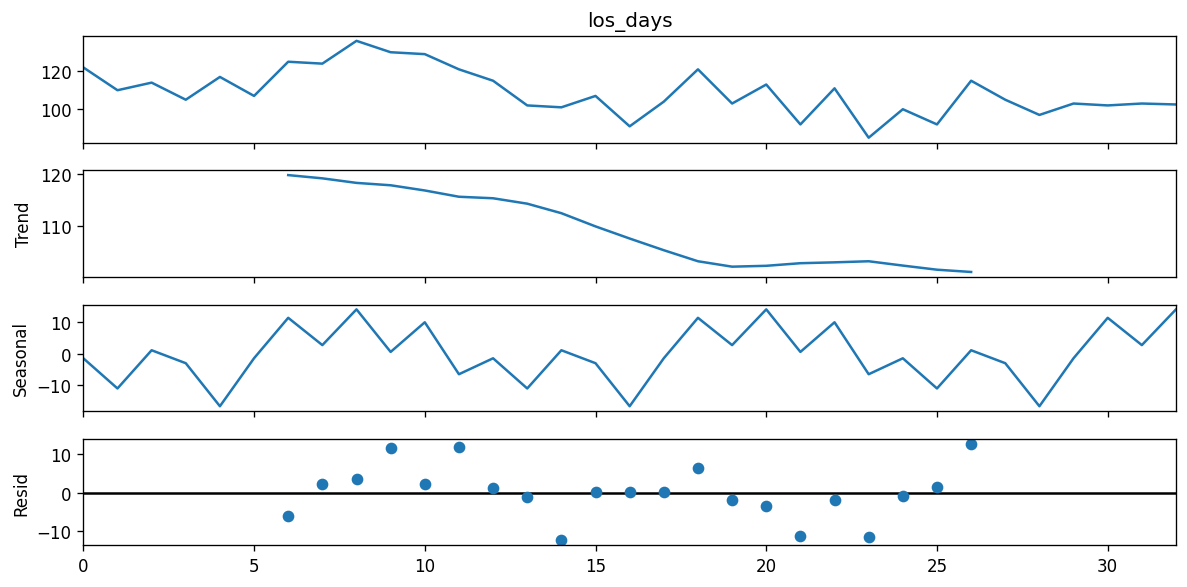

In [45]:
#decompose the monthly admission count
results = seasonal_decompose(_30day_pop_tot['los_days'],model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

Determine stationality of signal

In [46]:
result = adfuller(_30day_pop_tot['admission_count'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.118697
p-value: 0.237063
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


In [47]:
result = adfuller(_30day_pop_tot['discharge_count'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.489712
p-value: 0.117998
Critical Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


In [48]:
result = adfuller(_30day_pop_tot['los_days'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.575432
p-value: 0.495922
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


Based on the p-value for the adf test above, none of these signals are stationary. Let's determine the differencing order we need to use for our ARIMA model.

In [49]:
result = adfuller(_30day_pop_tot['admission_count'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.989936
p-value: 0.000000
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


In [50]:
result = adfuller(_30day_pop_tot['discharge_count'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.333582
p-value: 0.000000
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


In [51]:
result = adfuller(_30day_pop_tot['los_days'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.265666
p-value: 0.000000
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


The 1st difference of the series is stationary with a confidence level of 95%. Let's now investigate the PACF and ACF of the original and differenced series.

Text(0.5, 1.0, 'Partial Autocorrelation')

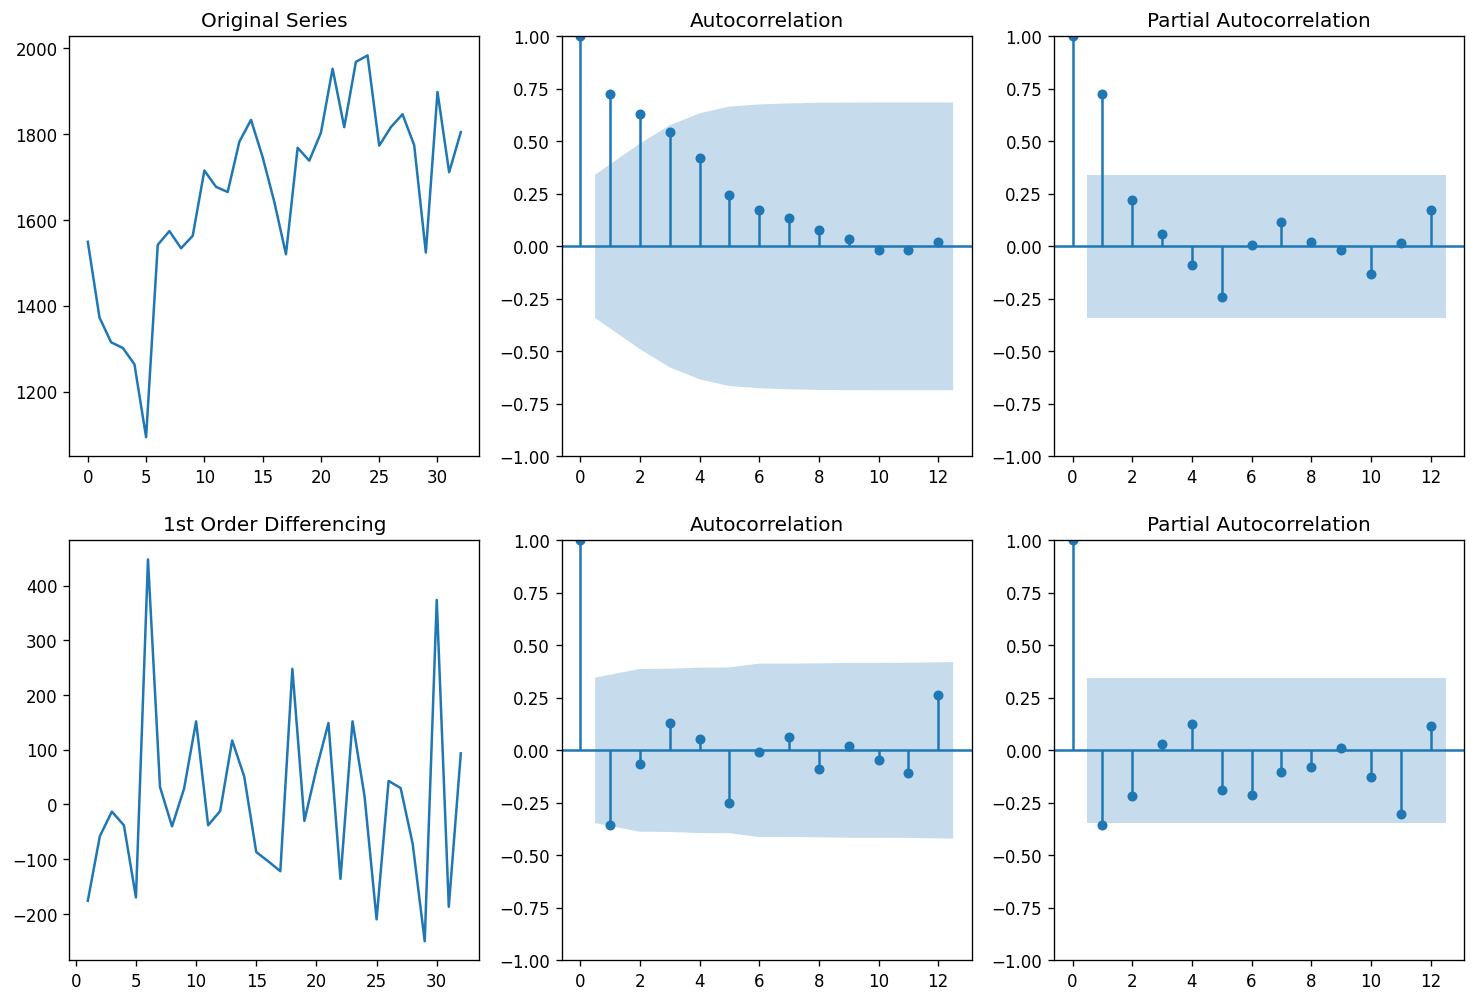

In [52]:
ts = _30day_pop_tot['admission_count']
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')

plot_acf(ts, lags = 12, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(ts, lags = 12, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(ts.diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(ts.diff().dropna(), lags = 12, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(ts.diff().dropna(), lags = 12, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

Text(0.5, 1.0, 'Partial Autocorrelation')

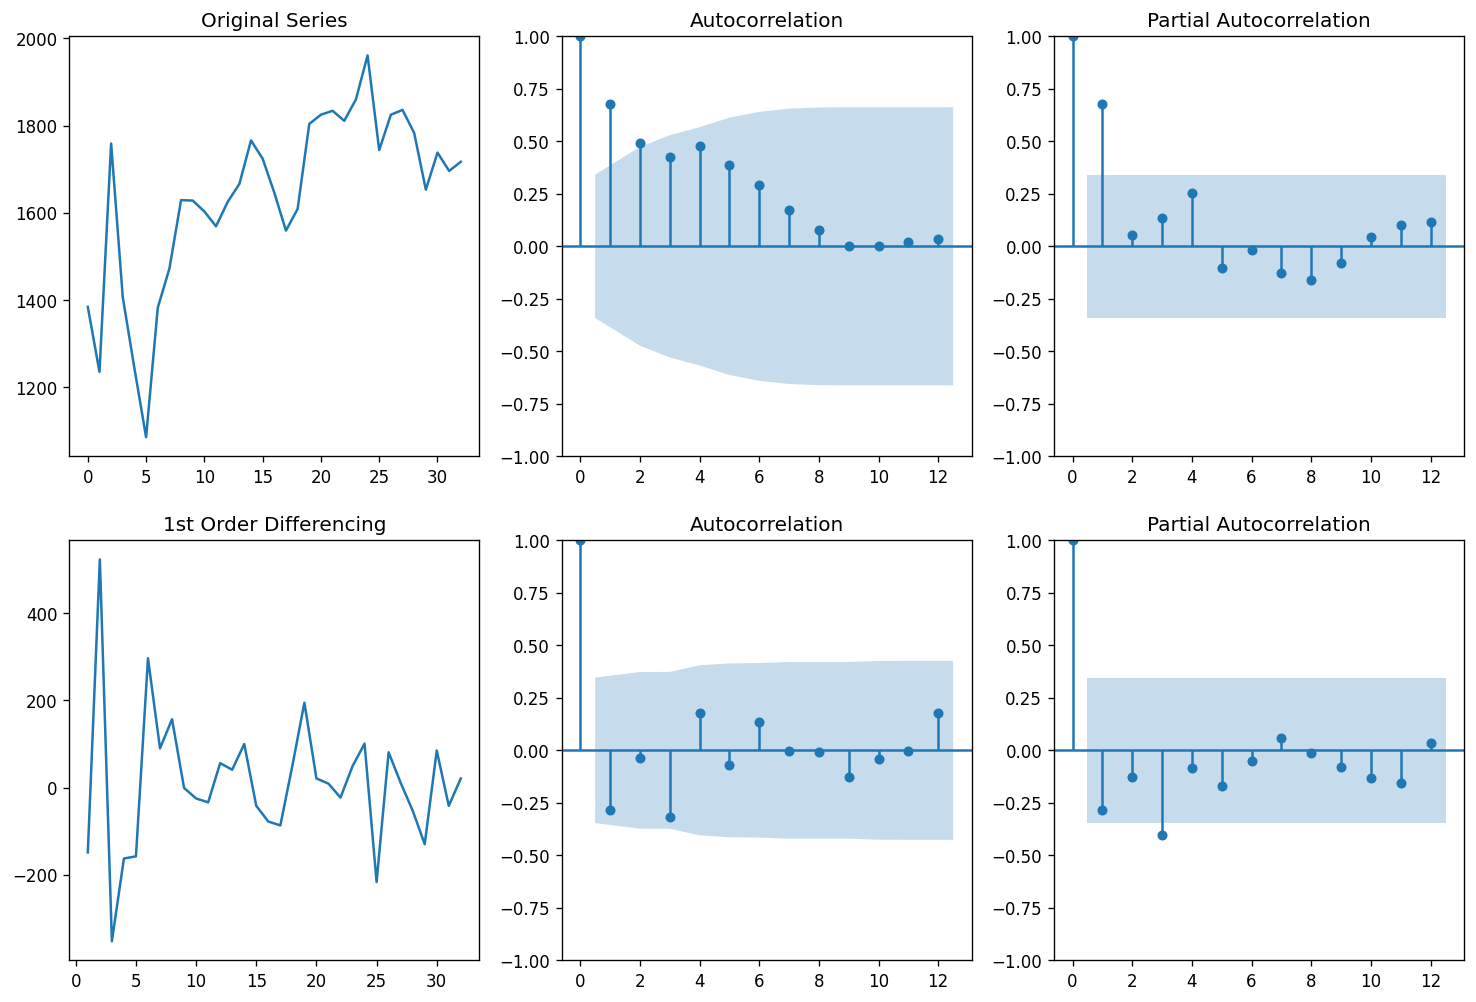

In [53]:
ts = _30day_pop_tot['discharge_count']
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')

plot_acf(ts, lags = 12, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(ts, lags = 12, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(ts.diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(ts.diff().dropna(), lags = 12, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(ts.diff().dropna(), lags = 12, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

Text(0.5, 1.0, 'Partial Autocorrelation')

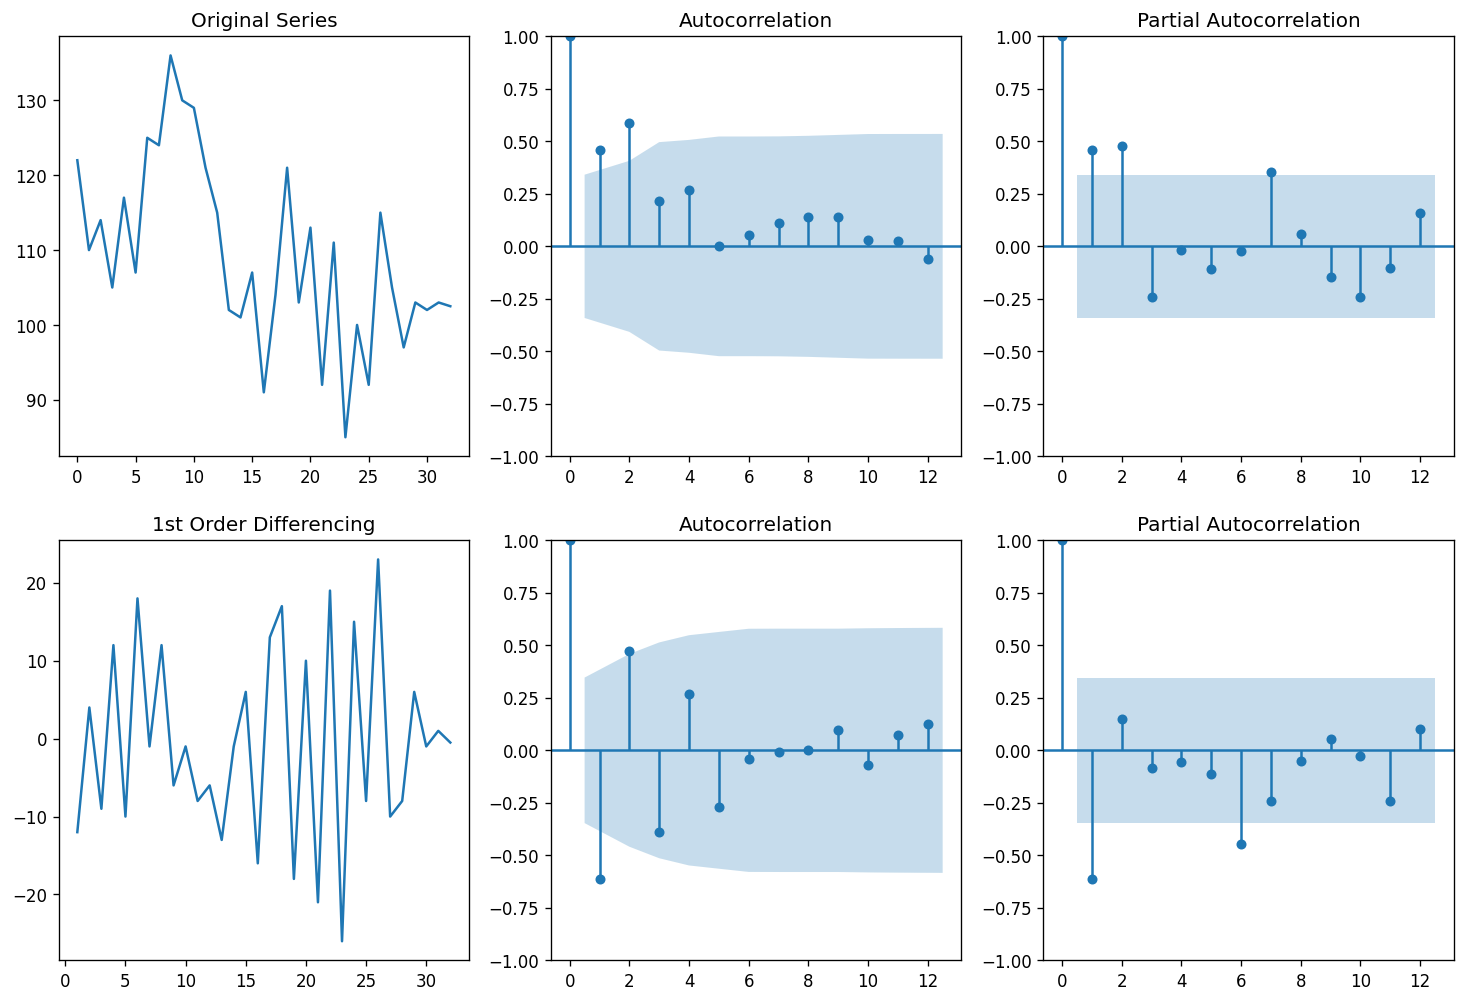

In [54]:
ts = _30day_pop_tot['los_days']
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')

plot_acf(ts, lags = 12, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(ts, lags = 12, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(ts.diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(ts.diff().dropna(), lags = 12, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(ts.diff().dropna(), lags = 12, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

### Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Recall that:

* **q:** The size of the moving average window, or the number of the moving average terms, also called the order of moving average.

* **p:** The number of AR terms included in the model, also called the lag order.

Autoregressive models: AR(p)

moving average models: MA(q)

mixed autoregressive moving average models: ARMA(p, q)

integration models: ARIMA(p, d, q)

seasonal models: SARIMA(P, D, Q, s)

Based on the information above, the ARIMA coefficients should be:

30-day admission counts: (p,d,q) = (1,1,0)

30-day discharge counts: (p,d,q) = (4,1,0)

30-day length of stay: (p,d,q) = (1,1,0)

The in sample MAE is:  166.16707511326783
The out of sample MAE is:  79.67922031879344
                               SARIMAX Results                                
Dep. Variable:        admission_count   No. Observations:                   26
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -159.152
Date:                Mon, 01 Apr 2024   AIC                            322.304
Time:                        14:26:37   BIC                            324.742
Sample:                             0   HQIC                           322.980
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2204      0.261     -0.843      0.399      -0.733       0.292
sigma2      1.987e+04   6437.030      3.086 

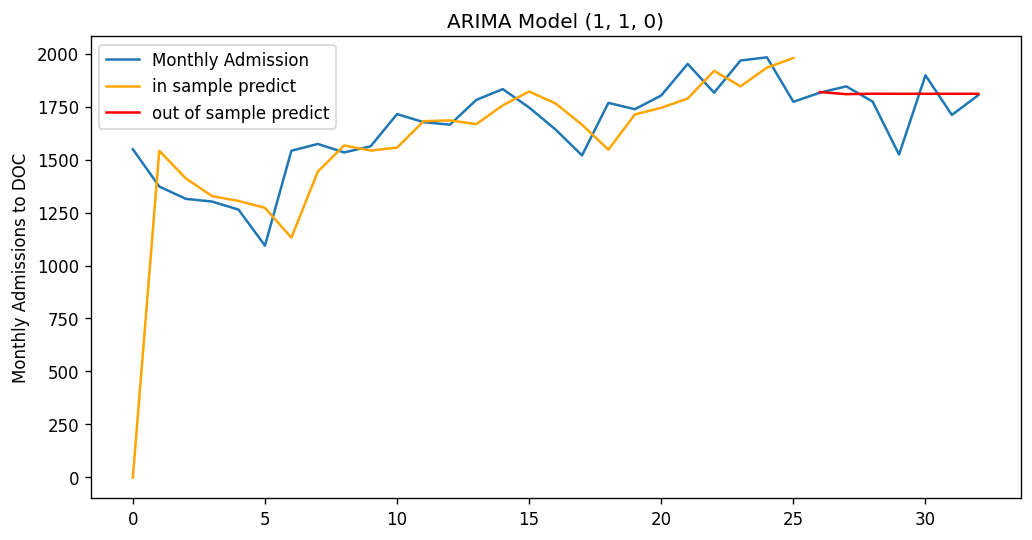

In [55]:
p=1
d=1
q=0
order = (p,d,q)
# fit model
series = _30day_pop_tot['admission_count']
train_size = int(len(series)*0.8)
#train test split
series_train =  series.iloc[:train_size]
series_test = series.iloc[train_size:]

model = sm.tsa.ARIMA(series_train, order=order)
model_fit = model.fit()
train_predictions = model_fit.predict()
pred = model_fit.get_forecast(steps=len(series_test))
fc_series = pd.Series(pred.summary_frame()['mean'].values)
is_mae = mean_absolute_error(series_train, train_predictions)
os_mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The in sample MAE is: ', is_mae)
print('The out of sample MAE is: ', os_mae)
print(model_fit.summary())

#plot
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admission') # train
ax.plot(series_train.index,train_predictions,color='orange',label='in sample predict') # in-sample
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order}')
plt.legend()
plt.show()

The in sample MAE is:  195.28286954876498
The out of sample MAE is:  100.68516741841374
                               SARIMAX Results                                
Dep. Variable:        discharge_count   No. Observations:                   26
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -160.447
Date:                Mon, 01 Apr 2024   AIC                            330.894
Time:                        14:26:37   BIC                            336.989
Sample:                             0   HQIC                           332.585
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3140      0.204     -1.540      0.124      -0.714       0.086
ar.L2         -0.0451      0.103     -0.440

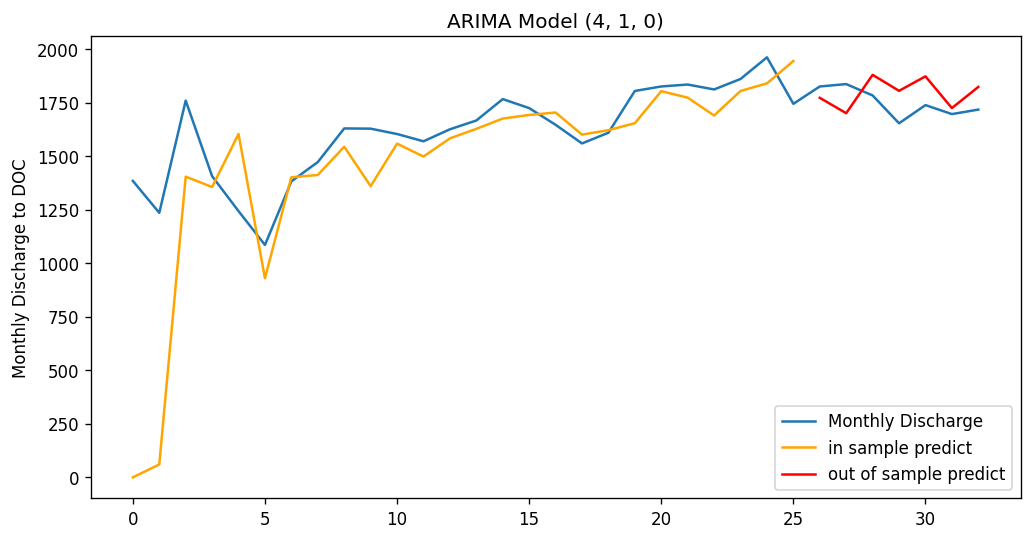

In [56]:
p=4
d=1
q=0
order = (p,d,q)
# fit model
series = _30day_pop_tot['discharge_count']
train_size = int(len(series)*0.8)
#train test split
series_train =  series.iloc[:train_size]
series_test = series.iloc[train_size:]

model = sm.tsa.ARIMA(series_train, order=order)
model_fit = model.fit()
train_predictions = model_fit.predict()
pred = model_fit.get_forecast(steps=len(series_test))
fc_series = pd.Series(pred.summary_frame()['mean'].values)
is_mae = mean_absolute_error(series_train, train_predictions)
os_mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The in sample MAE is: ', is_mae)
print('The out of sample MAE is: ', os_mae)
print(model_fit.summary())

#plot
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Discharge') # train
ax.plot(series_train.index,train_predictions,color='orange',label='in sample predict') # in-sample
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Monthly Discharge to DOC')
plt.title(f'ARIMA Model {order}')
plt.legend()
plt.show()

The in sample MAE is:  12.688276119153166
The out of sample MAE is:  8.651633727079531
                               SARIMAX Results                                
Dep. Variable:               los_days   No. Observations:                   26
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -93.163
Date:                Mon, 01 Apr 2024   AIC                            190.325
Time:                        14:26:38   BIC                            192.763
Sample:                             0   HQIC                           191.001
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6322      0.189     -3.341      0.001      -1.003      -0.261
sigma2        98.9678     32.471      3.048 

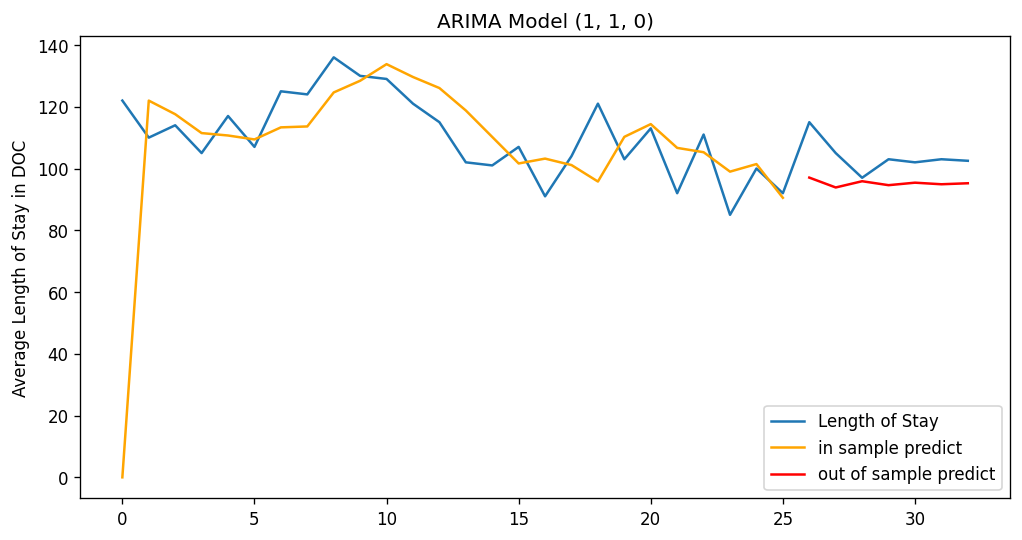

In [57]:
p=1
d=1
q=0
order = (p,d,q)
# fit model
series = _30day_pop_tot['los_days']
train_size = int(len(series)*0.8)
#train test split
series_train =  series.iloc[:train_size]
series_test = series.iloc[train_size:]

model = sm.tsa.ARIMA(series_train, order=order)
model_fit = model.fit()
train_predictions = model_fit.predict()
pred = model_fit.get_forecast(steps=len(series_test))
fc_series = pd.Series(pred.summary_frame()['mean'].values)
is_mae = mean_absolute_error(series_train, train_predictions)
os_mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The in sample MAE is: ', is_mae)
print('The out of sample MAE is: ', os_mae)
print(model_fit.summary())

#plot
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Length of Stay') # train
ax.plot(series_train.index,train_predictions,color='orange',label='in sample predict') # in-sample
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Average Length of Stay in DOC')
plt.title(f'ARIMA Model {order}')
plt.legend()
plt.show()

Let's check whether the auto_arima algorithm would give the same coefficients as we determined above.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=415.419, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=417.642, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=413.884, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=414.630, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=415.726, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=415.061, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=413.335, Time=0.19 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=415.205, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=415.187, Time=0.12 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=414.985, Time=0.14 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=413.498, Time=0.26 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=416.612, Time=0.22 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=415.696, Time=0.19 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=415.914, Time=0.28 sec
 ARIMA(1,1,0)(2,0,0)[12]         

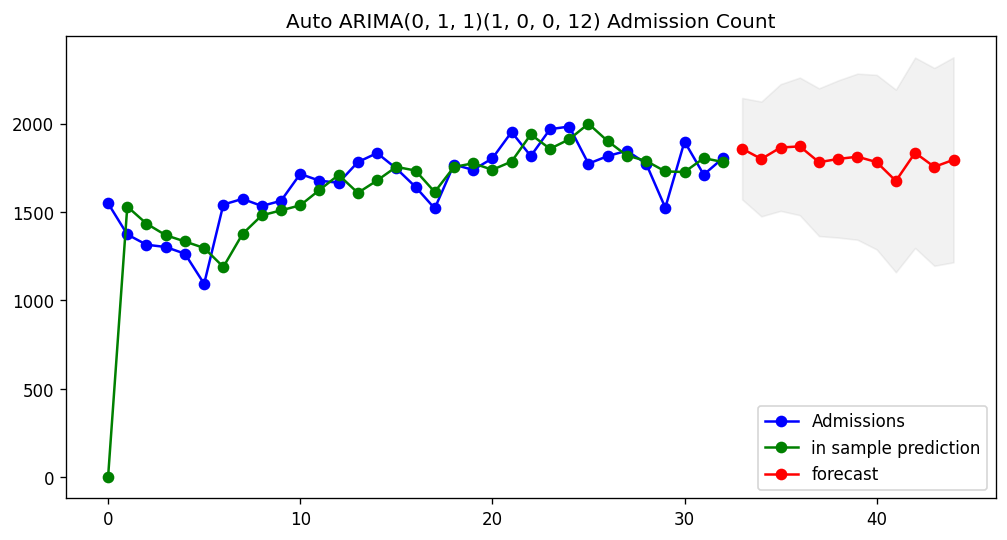

In [58]:
# Fit a simple auto_arima model
auto_arima = pm.auto_arima(_30day_pop_tot['admission_count'], error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)
#in sample
in_sample = auto_arima.predict_in_sample()
# Create predictions for the future, evaluate on test
preds, conf_int = auto_arima.predict(n_periods=12, return_conf_int=True)

#plot
plt.plot(_30day_pop_tot.index,_30day_pop_tot['admission_count'],'bo-', label = 'Admissions')
plt.plot(_30day_pop_tot.index, in_sample,'go-',label = 'in sample prediction')  # Forecasts
plt.plot(np.arange(len(_30day_pop_tot),len(_30day_pop_tot)+12), preds,'ro-',label = 'forecast')  # Forecasts
plt.fill_between(np.arange(len(_30day_pop_tot),len(_30day_pop_tot)+12),
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='grey')
plt.legend(loc = 'lower right')
plt.title(f"Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} Admission Count")
plt.show()

In [59]:
print(auto_arima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   33
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -202.268
Date:                             Mon, 01 Apr 2024   AIC                            410.536
Time:                                     14:26:43   BIC                            414.933
Sample:                                          0   HQIC                           411.994
                                              - 33                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4706      0.226     -2.084      0.037      -0.913      -0.028
ar.S.L12       0.4255      

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=433.452, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=417.202, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=415.109, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=414.539, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=415.348, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=421.055, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=416.042, Time=0.12 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=413.738, Time=0.19 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=415.960, Time=0.28 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=418.474, Time=0.41 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=417.685, Time=0.25 sec
 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=421.991, Time=0.23 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=416.926, Time=0.18 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(0,0,2)[12]             

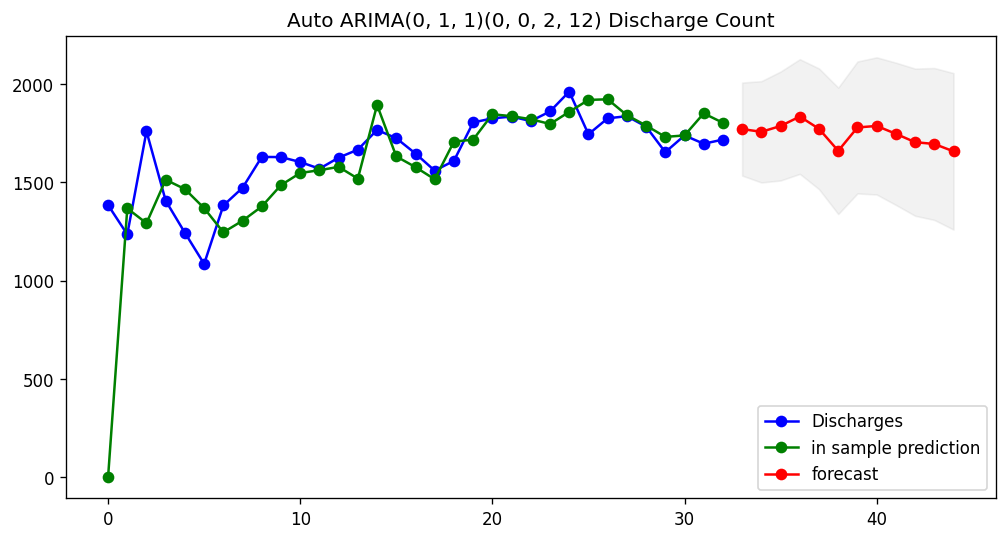

In [60]:
# Fit a simple auto_arima model
auto_arima = pm.auto_arima(_30day_pop_tot['discharge_count'], error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

#in sample
in_sample = auto_arima.predict_in_sample()
# Create predictions for the future, evaluate on test
preds, conf_int = auto_arima.predict(n_periods=12, return_conf_int=True)

#plot
plt.plot(_30day_pop_tot.index,_30day_pop_tot['discharge_count'],'bo-', label = 'Discharges')
plt.plot(_30day_pop_tot.index, in_sample,'go-',label = 'in sample prediction')  # Forecasts
plt.plot(np.arange(len(_30day_pop_tot),len(_30day_pop_tot)+12), preds,'ro-',label = 'forecast')  # Forecasts
plt.fill_between(np.arange(len(_30day_pop_tot),len(_30day_pop_tot)+12),
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='grey')
plt.legend(loc = 'lower right')
plt.title(f"Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} Discharge Count")
plt.show()

In [61]:
print(auto_arima.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                   33
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood                -202.139
Date:                                 Mon, 01 Apr 2024   AIC                            412.278
Time:                                         14:26:47   BIC                            418.141
Sample:                                              0   HQIC                           414.221
                                                  - 33                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5683      0.182     -3.119      0.002      -0.925      -0

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=251.882, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=255.951, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=244.054, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=248.781, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=254.029, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=242.731, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=244.002, Time=0.08 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=246.025, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=244.058, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=243.900, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=247.286, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=246.174, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=240.922, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=242.221, Time=0.11 sec
 ARIMA(1,1,0)(0,0,1)[12]         

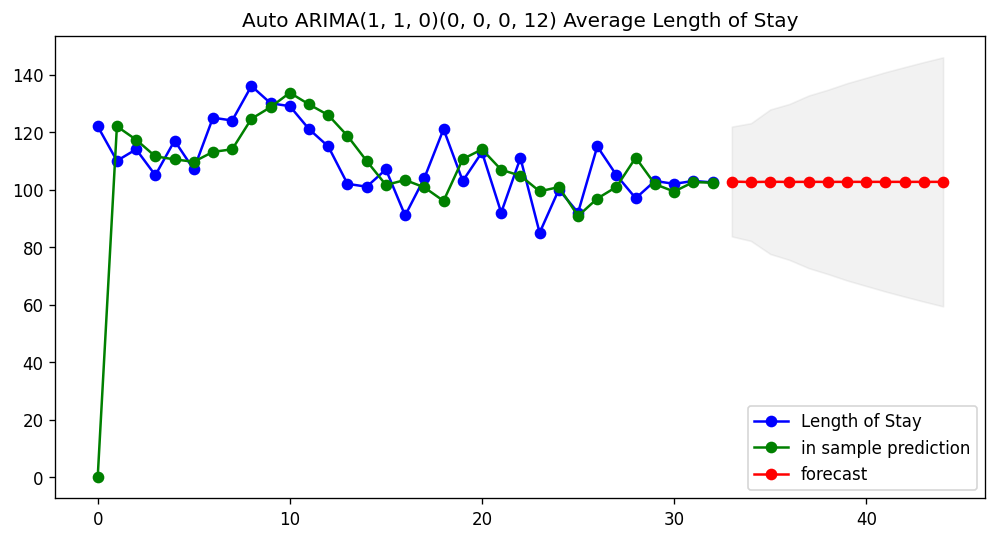

In [62]:
# Fit a simple auto_arima model
auto_arima = pm.auto_arima(_30day_pop_tot['los_days'], error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

#in sample
in_sample = auto_arima.predict_in_sample()
# Create predictions for the future, evaluate on test
preds, conf_int = auto_arima.predict(n_periods=12, return_conf_int=True)

#plot
plt.plot(_30day_pop_tot.index,_30day_pop_tot['los_days'],'bo-', label = 'Length of Stay')
plt.plot(_30day_pop_tot.index, in_sample,'go-',label = 'in sample prediction')  # Forecasts
plt.plot(np.arange(len(_30day_pop_tot),len(_30day_pop_tot)+12), preds,'ro-',label = 'forecast')  # Forecasts
plt.fill_between(np.arange(len(_30day_pop_tot),len(_30day_pop_tot)+12),
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='grey')
plt.legend(loc = 'lower right')
plt.title(f"Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} Average Length of Stay")
plt.show()

In [63]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -118.461
Date:                Mon, 01 Apr 2024   AIC                            240.922
Time:                        14:26:48   BIC                            243.854
Sample:                             0   HQIC                           241.894
                                 - 33                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6110      0.159     -3.843      0.000      -0.923      -0.299
sigma2        94.7676     25.515      3.714      0.000      44.759     144.776
Ljung-Box (L1) (Q):                   0.27   Jarque-

We will use the forecasts obtained by these models to predict ADP in the script `03_model_training_and_cross_val.ipynb`.